In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import quad
import langevin

In [2]:
# here we define the values of the physical parameters
# all energies are in kT = 4e-21J and lengths are in micrometers
# kappa = 10kT, sigma = 0.5 microJ/m^2, gamma = 0.1MJ/m^4, eta = 1.0mPa s
kappa = 10
sigma = 125
ga = 25
eta= 0.25
qmin=np.sqrt(3)/10

Here we describe the system in a continuous way

In [3]:
def gamma(q, kappa=kappa, sigma=sigma, ga=ga, eta=eta ):
    return (kappa*q**4+sigma*q**2+ga)/(4*eta*q)

In [4]:
def avg(q,resolution):
    return (np.exp(-gamma(q)*resolution)-1.0+gamma(q)*resolution)/(gamma(q)**2*resolution**2)

In [5]:
def integrant(q,t):
    return q*np.exp(-gamma(q)*t)/(kappa*q**4+sigma*q**2+ga)*avg(q,1e-6)*np.exp(-0.25*0.5**2*q**2)

In [6]:
time=np.logspace(-5,0,50)

In [7]:
acf=[quad(integrant,qmin,np.inf,args=(t))[0] for t in time]

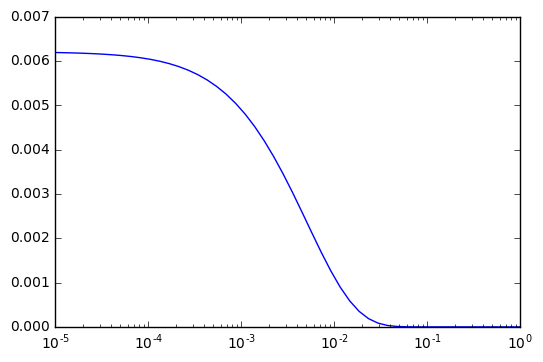

In [8]:
plt.semilogx(time,acf)

lets try the discrete one.  Here we assume that we have a $q_{min}$ and that $q^2=q_{x}^2+q_{y}^2$ where each $q_{x}=lq_{min}$ and $q_{y}=mq_{min}$ which results in $q_{lm}=q_{min}\sqrt{l^2+m^2}$

In [35]:
q_list=[np.sqrt(l**2+m**2) for l in range(0,4) for m in range(0,4)]

In [36]:
q_list=np.array(sorted(q_list)[1:])
print(q_list.size)
print(q_list)

15
[ 1.          1.          1.41421356  2.          2.          2.23606798
  2.23606798  2.82842712  3.          3.          3.16227766  3.16227766
  3.60555128  3.60555128  4.24264069]


In [11]:
def corrfct(t,q_list):
    corr=np.exp(-gamma(q_list)*t)/(kappa*q_list**4+sigma*q_list**2+ga)*avg(q_list,1e-6)*np.exp(-0.25*0.5**2*q_list**2)
    return corr.sum()

In [12]:
acf_d = np.array([corrfct(t,q_list) for t in time])

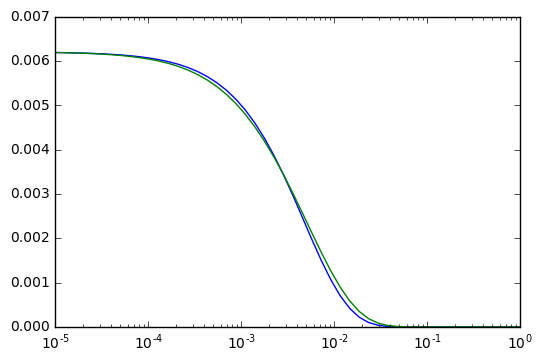

In [13]:
# plot correlation functions and normalize them to the same msd
plt.semilogx(time,acf_d*acf[0]/acf_d[0])
plt.semilogx(time,acf)

In [47]:
delta_t = 0.00001
ts_all = None
for q in q_list:
    ts = langevin.time_series2(1/(kappa*q**4+sigma*q**2+ga),gamma(q),delta_t,100000)
    print(1/(kappa*q**4+sigma*q**2+ga),gamma(q))
    if ts_all is None:
        ts_all = ts
    else:
        ts_all = ts_all + ts



0.00625 160.0
0.00625 160.0
0.0031746031746 222.738636074
0.0014598540146 342.5
0.0014598540146 342.5
0.00111111111111 402.49223595
0.00111111111111 402.49223595
0.000600600600601 588.666395338
0.000510204081633 653.333333333
0.000510204081633 653.333333333
0.00043956043956 719.418167688
0.00043956043956 719.418167688
0.000299401197605 926.349327696
0.000299401197605 926.349327696
0.000181323662738 1299.89796608


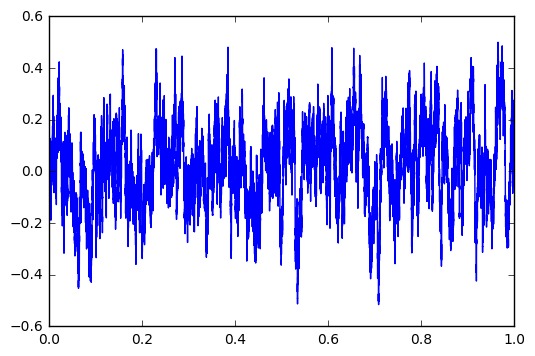

In [48]:
plt.plot(np.arange(ts_all.size)*delta_t,ts_all)

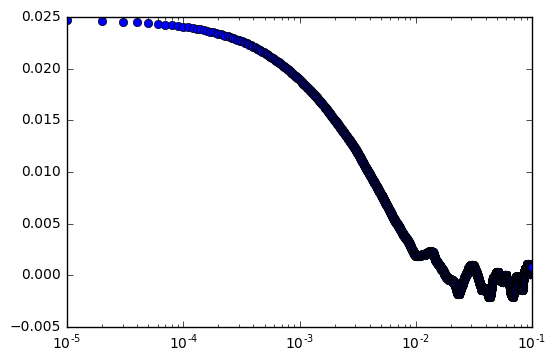

In [49]:
N = ts_all.size
# calculate autocorrelation function
f = np.fft.rfft(ts_all)
acf = np.fft.irfft(f * np.conjugate(f))
acf = np.fft.fftshift(acf) / N
autocorr = acf[int(N / 2):]

autocorr = autocorr[:10000]
t = np.arange(autocorr.size)*delta_t
plt.semilogx(t, autocorr,"o")